# FlowScope: Spotting Money Laundering Based on Graphs

## Set-up environment

For this notebook, a dedicated virtual environment is set up. Some care is needed due to problems with dependencies after migration to [spartan](https://github.com/BGT-M/spartan2). This is based on the solution provided on this [issue](https://github.com/BGT-M/spartan2/issues/66).

We have constructed the virtual environment as follows: 
```bash
conda create -n spartan python=3.10
conda activate spartan
conda install cython==0.29.36
pip install spartan2
```

This way of create the virtual environment seems to be sufficient to let the example in this notebook run. 

## Abstract

Given a graph of the money transfers between accounts of
a bank, how can we detect money laundering? Money laundering refers to criminals using the bank’s services to move
massive amounts of illegal money to untraceable destination
accounts, in order to inject their illegal money into the legitimate financial system. Existing graph fraud detection approaches focus on dense subgraph detection, without considering the fact that money laundering involves high-volume
flows of funds through chains of bank accounts, thereby
decreasing their detection accuracy. Instead, we propose to
model the transactions using a multipartite graph, and detect the complete flow of money from source to destination
using a scalable algorithm, FlowScope. Theoretical analysis
shows that FlowScope provides guarantees in terms of the
amount of money that fraudsters can transfer without being
detected. FlowScope outperforms state-of-the-art baselines in
accurately detecting the accounts involved in money laundering, in both injected and real-world data settings.


In [1]:
import spartan as st

Using backend cpu


In [2]:
import pandas as pd
fs1_data = pd.read_csv("./inputData/fs_in_data.csv.gz", header=None)
fs1_data.head()

,0,1,2
0,0,3009,1000
1,1,915,937
2,2,3061,0
3,3,55,6000
4,4,939,157


In [3]:
# load graph data
fs1_tensor_data = st.loadTensor(path = "./inputData/fs_in_data.csv.gz", header=None)
fs2_tensor_data = st.loadTensor(path = "./inputData/fs_out_data.csv.gz", header=None)

In [4]:
fs1_tensor_data.data

,0,1,2
0,0,3009,1000
1,1,915,937
2,2,3061,0
3,3,55,6000
4,4,939,157
...,...,...,...
2188,1330,2578,7760
2189,1331,2019,4588
2190,1278,2287,4300
2191,1332,3035,600


"tensor_data.data" has two-colum attributes, and a single-colum values. The following table shows an example of 1000 two-tuple (source account id, destination account id) and the 3th-colum is the money.

| row id |    0    |    1    |    2   |
| :----  | :----   | :----   | :----  |
| 0 | 0  |  3009   | 1000 |
| 1 | 1  |  915   | 937 |
| 2 | 2  |  3061   | 0 |
| 3 | 3  |  55   | 6000 |
| 4 | 4  |  939   | 157 |
| ... | ...  |  ...  | ... |
|995|	621	|3328 |	50000
|996|	622	|1278 |	3100
|997|	623	|2470 |	3000
|998|	375	|1350 |	20000
|999|	624	|3329 |	1000


In [5]:
fs2_tensor_data.data

,0,1,2
0,0,259,30320
1,1,260,5000
2,3,261,10000
3,4,262,4000
4,5,263,400
...,...,...,...
2596,2200,192,24878
2597,2201,1907,200
2598,1971,113,3
2599,533,734,250


In [6]:
fs1_stensor = fs1_tensor_data.toSTensor(hasvalue=True)
fs2_stensor = fs2_tensor_data.toSTensor(hasvalue=True)

In [7]:
fs1_stensor._data

Format,coo
Data Type,int64
Shape,"(1334, 3430)"
nnz,2006
Density,0.00043841053234315786
Read-only,True
Size,47.0K
Storage ratio,0.00


In [8]:
fs2_stensor._data

Format,coo
Data Type,int64
Shape,"(2203, 1909)"
nnz,2315
Density,0.0005504660890299837
Read-only,True
Size,54.3K
Storage ratio,0.00


Sparse tensors "fs1_stensor" and "fs2_stensor" are matrices constructed from tensor_data. The amounts of money are elements in those matrices.

The size of fs1_stensor in this example is $1334 \times 3430 $, and the size of fs2_stensor is $2203 \times 1909 $.

In [9]:
maxshape = max(fs1_stensor.shape[1], fs2_stensor.shape[0])
fs1_stensor.shape = (fs1_stensor.shape[0], maxshape)
fs2_stensor.shape = (maxshape, fs2_stensor.shape[1])

Change the shape of two stensors, make sure they have the same size in middle dimension.

In this case, those matrices have sizes of $1334 \times 3430$ and $3430 \times 1909$

In [10]:
graph_1 = st.Graph(fs1_stensor, bipartite=True, weighted=True, modet=None)
graph_2 = st.Graph(fs2_stensor, bipartite=True, weighted=True, modet=None)

Get graph instances from sparse tensors.

In [11]:
step2list = []
step2list.append(graph_1)
step2list.append(graph_2)

Create a graph list, and add graphs in order

### Run FlowScope as a single model

In [12]:
fs = st.FlowScope(step2list)

Note: This model does not support GPU, so it will not be accelerated in GPU mode

In [13]:
print(fs)

{'graphnum': 2, 'graphlist': [<spartan.tensor.graph.Graph object at 0x1620365c0>, <spartan.tensor.graph.Graph object at 0x162037880>]}


Default parameters are: {'alpha': '4'}

alpha is equivalent to $\lambda$ in the paper

In [14]:
res = fs.run(k=3, alpha=4,maxsize=(10,10,10))

you are running with  3  partite graph
this is the cpu version of FlowScope
start  greedy
initial score of g(S): -19063.209800689343
best delete number :  6647
nodes number remaining:  3 0 3 
matrix mass remaining:  0.0 0.0 
best score of g(S):  14313.653846153848
min value of the tree :  (11, 0.0) (0, inf) (250, 0.0) 
the block size is: 10 7 9 

this is the cpu version of FlowScope
start  greedy
initial score of g(S): -19053.298066836505
best delete number :  6658
nodes number remaining:  1 0 4 
matrix mass remaining:  0.0 0.0 
best score of g(S):  11218.333333333332
min value of the tree :  (529, 0.0) (0, inf) (1272, 0.0) 
the block size is: 3 3 9 

this is the cpu version of FlowScope
start  greedy
initial score of g(S): -19030.03371796793
best delete number :  6657
nodes number remaining:  3 0 5 
matrix mass remaining:  0.0 0.0 
best score of g(S):  9077.5625
min value of the tree :  (346, 0.0) (0, inf) (4, 0.0) 
the block size is: 6 3 7 



$k$ is the number of blocks you want to detect.

$res$ is a list of each block. Each block constains [[detected nodes in each partite], score]

### Run FlowScope from anomaly detection task

In [15]:
ad_model = st.AnomalyDetection.create(step2list, st.ADPolicy.FlowScope, 'flowscope')

In [16]:
# run the model
#default k=3, alpha=4
res = ad_model.run(k=1,alpha=4,maxsize=(-1,-1,100))

you are running with  3  partite graph
this is the cpu version of FlowScope
start  greedy
initial score of g(S): -19063.209800689343
best delete number :  6647
nodes number remaining:  3 0 3 
matrix mass remaining:  0.0 0.0 
best score of g(S):  14313.653846153848
min value of the tree :  (11, 0.0) (0, inf) (250, 0.0) 
the block size is: 10 7 9 



$maxsize$ is the block size limit.

$maxsize$ can be an integer (-1 or positive), and $maxsize==-1$ means no size limit.

$maxsize$ can be a tuple which contains the node size limit for each dimension of the block. Similarly, each element of $maxsize$ should be an integer (-1 or positive).

The results is a list of top-k suspicious blocks. Each block constains [[detected nodes in each partite], score]

Then we can visualize the subgraphs as follows.

In [17]:
res

[[[{11, 68, 216, 227, 651, 689, 723, 749, 1146, 1276},
   {117, 295, 426, 691, 708, 748, 1300},
   {25, 133, 250, 336, 360, 383, 457, 550, 769}],
  np.float64(14313.653846153848)]]

In [18]:
#viusal of graphs by networkx
import matplotlib.pyplot as plt
import numpy as np
for r in res:
    one, two, three = r[0]
    one = np.array(list(one))
    two = np.array(list(two))
    three = np.array(list(three))

In [19]:
one

array([  11,   68,  216,  227,  651,  689,  723,  749, 1146, 1276])

In [20]:
two

array([ 117,  295,  426,  691,  708,  748, 1300])

In [21]:
graph_1.get_sub_graph(one, two)

In [22]:
from networkx.algorithms.bipartite.matrix import from_biadjacency_matrix
import networkx as nx

In [23]:
graph_nx = from_biadjacency_matrix(graph_1.get_sub_graph(one, two).sm)

In [24]:
graph_nx.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16))

In [25]:
graph_nx.edges

EdgeView([(0, 10), (1, 12), (2, 15), (3, 14), (4, 11), (5, 16), (6, 10), (7, 13), (8, 13), (9, 10)])

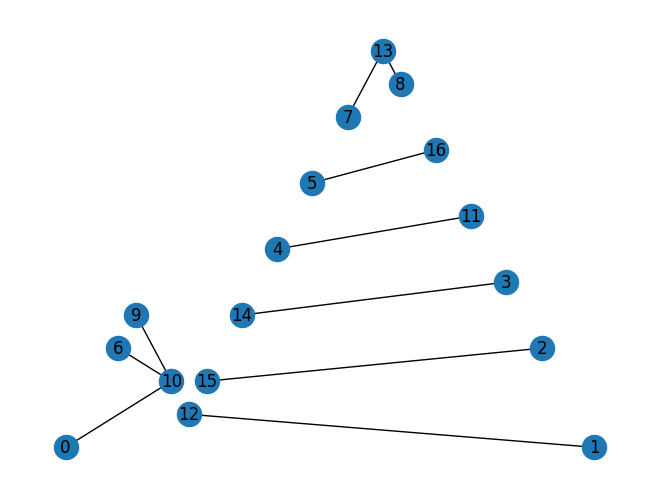

In [26]:
nx.draw_planar(graph_nx, with_labels=True)

# Benchmark study

In [1]:
import pandas as pd

transaction_data = pd.read_csv('inputData/synthetic/raw/edge_data_synthetic.csv')
transaction_data['money'] = 1
transaction_data.to_csv('inputData/synthetic/processed/edge_data_synthetic.csv', index=False, header=False)

In [2]:
import spartan as st
# load graph data
fs1_tensor_data = st.loadTensor(path = "./inputData/synthetic/processed/edge_data_synthetic.csv", header=None)
fs2_tensor_data = st.loadTensor(path = "./inputData/synthetic/processed/edge_data_synthetic.csv", header=None)

fs1_stensor = fs1_tensor_data.toSTensor(hasvalue=True)
fs2_stensor = fs2_tensor_data.toSTensor(hasvalue=True)

maxshape = max(fs1_stensor.shape[1], fs2_stensor.shape[0])
fs1_stensor.shape = (fs1_stensor.shape[0], maxshape)
fs2_stensor.shape = (maxshape, fs2_stensor.shape[1])

graph_1 = st.Graph(fs1_stensor, bipartite=True, weighted=True, modet=None)
graph_2 = st.Graph(fs2_stensor, bipartite=True, weighted=True, modet=None)

step2list = []
step2list.append(graph_1)
step2list.append(graph_2)

Using backend cpu


In [3]:
fs = st.FlowScope(step2list)
res = fs.run(k=3, alpha=4,maxsize=(10,10,10))

you are running with  3  partite graph
this is the cpu version of FlowScope
start  greedy
initial score of g(S): -1.9191489361702128
best delete number :  685
nodes number remaining:  2 0 2 
matrix mass remaining:  0.0 0.0 
best score of g(S):  0.6
min value of the tree :  (36, 0.0) (0, inf) (88, 0.0) 
the block size is: 5 10 5 

this is the cpu version of FlowScope
start  greedy
initial score of g(S): -1.9219858156028367
best delete number :  691
nodes number remaining:  1 0 1 
matrix mass remaining:  0.0 0.0 
best score of g(S):  0.7142857142857143
min value of the tree :  (209, 0.0) (0, inf) (213, 0.0) 
the block size is: 2 10 2 

this is the cpu version of FlowScope
start  greedy
initial score of g(S): -1.9361702127659572
best delete number :  702
nodes number remaining:  1 0 1 
matrix mass remaining:  0.0 0.0 
best score of g(S):  0.3333333333333333
min value of the tree :  (34, 0.0) (0, inf) (188, 0.0) 
the block size is: 1 1 1 



In [4]:
res

[[[{8, 17, 36, 62, 214},
   {29, 65, 215, 216, 217, 218, 219, 220, 221, 222},
   {88, 133, 135, 152, 223}],
  np.float64(0.6)],
 [[{200, 209}, {201, 202, 203, 204, 205, 206, 207, 210, 211, 212}, {208, 213}],
  np.float64(0.7142857142857143)],
 [[{34}, {186}, {188}], np.float64(0.3333333333333333)]]

In [20]:
num_nodes = max(set(transaction_data.source).union(set(transaction_data.target)))+1

laundering = []
number_list = []

keys_list = [i for i in range(num_nodes)]
values_list = [0]*len(keys_list)
map_scores = dict(zip(keys_list, values_list))

for i in range(len(res)):
    r = res[i][0]
    for d in r:
        d_list = list(d)
        for j in range(len(d_list)):
            map_scores[d_list[j]]= (3-i)/3
        laundering+=d_list
        number_list.append(i)

len(laundering)

37

In [25]:
from sklearn.metrics import roc_auc_score, average_precision_score

label_data = pd.read_csv('./inputData/synthetic/raw/label_data_synthetic.csv')
label_data['node'] = label_data.index
label_data['score'] = label_data['node'].map(map_scores)

# Calculate the AUC-ROC and AUC-PR
AUC_ROC = roc_auc_score(label_data['laundering'], label_data['score'])
AUC_PR = average_precision_score(label_data['laundering'], label_data['score'])

print('AUC-ROC: ', AUC_ROC)
print('AUC-PR: ', AUC_PR)


AUC-ROC:  0.6952380952380952
AUC-PR:  0.5253028348268768


# Full experiment

In [2]:
import pandas as pd
import spartan as st

def process_data(string_name):
    transaction_data = pd.read_csv('inputData/synthetic/raw/edge_data_'+string_name+'.csv')
    transaction_data['money'] = 1
    transaction_data.to_csv('inputData/synthetic/processed/edge_data_'+string_name+'.csv', index=False, header=False)

n_nodes_list = [200]#[100, 10000, 100000] # Number of nodes in the graph
m_edges_list = [2]#[1, 2, 5] # Number of edges to attach from a new node to existing nodes
p_edges_list = [0.01]#[0.001, 0.01] # Probability of adding an edge between two nodes
generation_method_list = [
    'Barabasi-Albert', 
    'Erdos-Renyi', 
    'Watts-Strogatz'
    ] # Generation method for the graph
n_patterns_list = [3]#[3, 5] # Number of smurfing patterns to add

for n_nodes in n_nodes_list:
    for n_patterns in n_patterns_list:
        if n_patterns <= 0.06*n_nodes:
            for generation_method in generation_method_list:
                if generation_method == 'Barabasi-Albert':
                    p_edges = 0
                    for m_edges in m_edges_list:
                        string_name = 'synthetic_' + generation_method + '_'  + str(n_nodes) + '_' + str(m_edges) + '_' + str(p_edges) + '_' + str(n_patterns)
                        process_data(string_name)

                if generation_method == 'Erdos-Renyi':
                    m_edges = 0
                    for p_edges in p_edges_list:
                        string_name = 'synthetic_' + generation_method + '_'  + str(n_nodes) + '_' + str(m_edges) + '_' + str(p_edges) + '_' + str(n_patterns)
                        process_data(string_name)

                if generation_method == 'Watts-Strogatz':
                    for m_edges in m_edges_list:
                        for p_edges in p_edges_list:
                            string_name = 'synthetic_' + generation_method + '_'  + str(n_nodes) + '_' + str(m_edges) + '_' + str(p_edges) + '_' + str(n_patterns)
                            process_data(string_name)

In [10]:
from sklearn.metrics import roc_auc_score, average_precision_score
def flowscope_synthetic(string_name):
    # load graph data
    transaction_data = pd.read_csv('inputData/synthetic/raw/edge_data_synthetic.csv')
    fs1_tensor_data = st.loadTensor(path = "./inputData/synthetic/processed/edge_data_"+string_name+".csv", header=None)
    fs2_tensor_data = st.loadTensor(path = "./inputData/synthetic/processed/edge_data_"+string_name+".csv", header=None)

    fs1_stensor = fs1_tensor_data.toSTensor(hasvalue=True)
    fs2_stensor = fs2_tensor_data.toSTensor(hasvalue=True)

    maxshape = max(fs1_stensor.shape[1], fs2_stensor.shape[0])
    fs1_stensor.shape = (fs1_stensor.shape[0], maxshape)
    fs2_stensor.shape = (maxshape, fs2_stensor.shape[1])

    graph_1 = st.Graph(fs1_stensor, bipartite=True, weighted=True, modet=None)
    graph_2 = st.Graph(fs2_stensor, bipartite=True, weighted=True, modet=None)

    step2list = []
    step2list.append(graph_1)
    step2list.append(graph_2)

    fs = st.FlowScope(step2list)
    res = fs.run(k=3, alpha=4,maxsize=(10,10,10))

    num_nodes = max(set(transaction_data.source).union(set(transaction_data.target)))+1

    laundering = []
    number_list = []

    keys_list = [i for i in range(num_nodes)]
    values_list = [0]*len(keys_list)
    map_scores = dict(zip(keys_list, values_list))

    for i in range(len(res)):
        r = res[i][0]
        for d in r:
            d_list = list(d)
            for j in range(len(d_list)):
                map_scores[d_list[j]]= (3-i)/3
            laundering+=d_list
            number_list.append(i)

    label_data = pd.read_csv('./inputData/synthetic/raw/label_data_'+string_name+'.csv')
    label_data['node'] = label_data.index
    label_data['score'] = label_data['node'].map(map_scores)
    label_data['score'] = label_data['score'].fillna(0)

    # Calculate the AUC-ROC and AUC-PR
    AUC_ROC = roc_auc_score(label_data['laundering'], label_data['score'])
    AUC_PR = average_precision_score(label_data['laundering'], label_data['score'])
    print("====", string_name, "====")
    print('AUC-ROC: ', AUC_ROC)
    print('AUC-PR: ', AUC_PR)
    print("==========================")


In [11]:
n_nodes_list = [200]#[100, 10000, 100000] # Number of nodes in the graph
m_edges_list = [2]#[1, 2, 5] # Number of edges to attach from a new node to existing nodes
p_edges_list = [0.01]#[0.001, 0.01] # Probability of adding an edge between two nodes
generation_method_list = [
    'Barabasi-Albert', 
    'Erdos-Renyi', 
    'Watts-Strogatz'
    ] # Generation method for the graph
n_patterns_list = [3]#[3, 5] # Number of smurfing patterns to add

for n_nodes in n_nodes_list:
    for n_patterns in n_patterns_list:
        if n_patterns <= 0.06*n_nodes:
            for generation_method in generation_method_list:
                if generation_method == 'Barabasi-Albert':
                    p_edges = 0
                    for m_edges in m_edges_list:
                        string_name = 'synthetic_' + generation_method + '_'  + str(n_nodes) + '_' + str(m_edges) + '_' + str(p_edges) + '_' + str(n_patterns)
                        print("====", string_name, "====")
                        flowscope_synthetic(string_name)

                if generation_method == 'Erdos-Renyi':
                    m_edges = 0
                    for p_edges in p_edges_list:
                        string_name = 'synthetic_' + generation_method + '_'  + str(n_nodes) + '_' + str(m_edges) + '_' + str(p_edges) + '_' + str(n_patterns)
                        print("====", string_name, "====")
                        flowscope_synthetic(string_name)

                if generation_method == 'Watts-Strogatz':
                    for m_edges in m_edges_list:
                        for p_edges in p_edges_list:
                            string_name = 'synthetic_' + generation_method + '_'  + str(n_nodes) + '_' + str(m_edges) + '_' + str(p_edges) + '_' + str(n_patterns)
                            print("====", string_name, "====")
                            flowscope_synthetic(string_name)

==== synthetic_Barabasi-Albert_200_2_0_3 ====
you are running with  3  partite graph
this is the cpu version of FlowScope
start  greedy
initial score of g(S): -2.7521489971346704
best delete number :  689
nodes number remaining:  4 0 4 
matrix mass remaining:  0.0 0.0 
best score of g(S):  0.4444444444444444
min value of the tree :  (23, 0.0) (0, inf) (86, 0.0) 
the block size is: 4 1 4 

this is the cpu version of FlowScope
start  greedy
initial score of g(S): -2.653295128939828
best delete number :  680
nodes number remaining:  3 0 3 
matrix mass remaining:  0.0 0.0 
best score of g(S):  0.4444444444444444
min value of the tree :  (10, 0.0) (0, inf) (135, 0.0) 
the block size is: 7 3 8 

this is the cpu version of FlowScope
start  greedy
initial score of g(S): -2.7492836676217762
best delete number :  684
nodes number remaining:  2 0 2 
matrix mass remaining:  0.0 0.0 
best score of g(S):  0.42857142857142855
min value of the tree :  (30, 0.0) (0, inf) (137, 0.0) 
the block size is: 